# Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import pickle as pkl

# Read Data

In [22]:
data = pd.read_csv("Social_Network_Ads.csv")
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


# Do a Train-Test Split

In [23]:
# After doing some tests, I found out that Gender is pretty much irrelevant
x_train, x_test, y_train, y_test = train_test_split(data[["Age", "EstimatedSalary"]], data["Purchased"], test_size=0.2, random_state=42)

# Fitting the model

In [24]:
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
 [[50  2]
 [ 7 21]]
Accuracy: 0.8875
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        52
           1       0.91      0.75      0.82        28

    accuracy                           0.89        80
   macro avg       0.90      0.86      0.87        80
weighted avg       0.89      0.89      0.88        80



In [25]:
x_train

,Age,EstimatedSalary
3,27,57000
18,46,28000
202,39,134000
250,44,39000
274,57,26000
...,...,...
71,24,27000
106,26,35000
270,43,133000
348,39,77000


In [26]:
log_reg.fit(x_train.drop("EstimatedSalary", axis=1), y_train)
y_pred = log_reg.predict(x_test.drop("EstimatedSalary", axis=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
 [[50  2]
 [ 5 23]]
Accuracy: 0.9125
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93        52
           1       0.92      0.82      0.87        28

    accuracy                           0.91        80
   macro avg       0.91      0.89      0.90        80
weighted avg       0.91      0.91      0.91        80



Hmm...seems like estimated salary adds some noise to the data.

We *CAN* stop here, but I want to see how far we can go with this

# Exploring this feature further

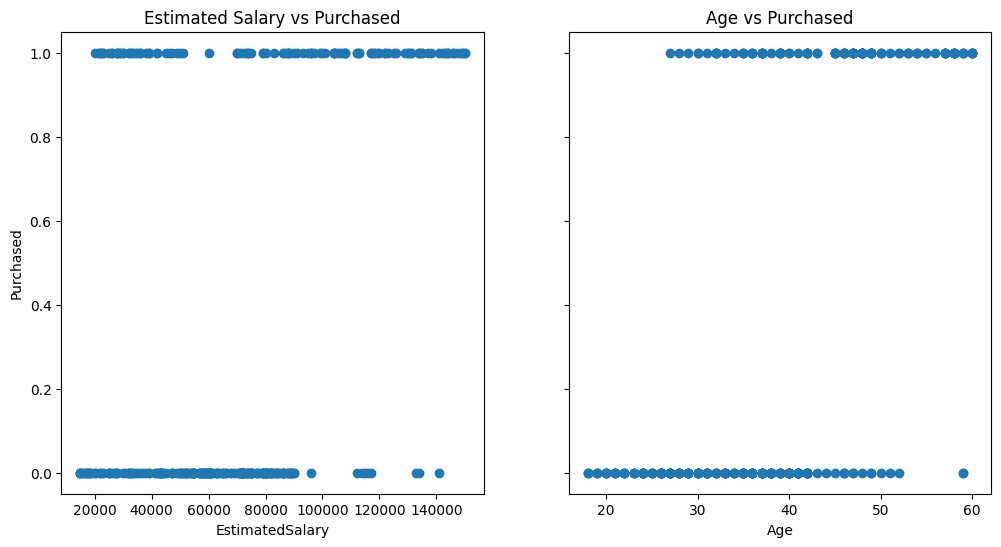

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax1.scatter(x=x_train["EstimatedSalary"], y=y_train)
ax1.set_xlabel("EstimatedSalary")
ax1.set_ylabel("Purchased")
ax1.set_title("Estimated Salary vs Purchased")

ax2.scatter(x=x_train["Age"], y=y_train)
ax2.set_xlabel("Age")
ax2.set_title("Age vs Purchased")

plt.show()

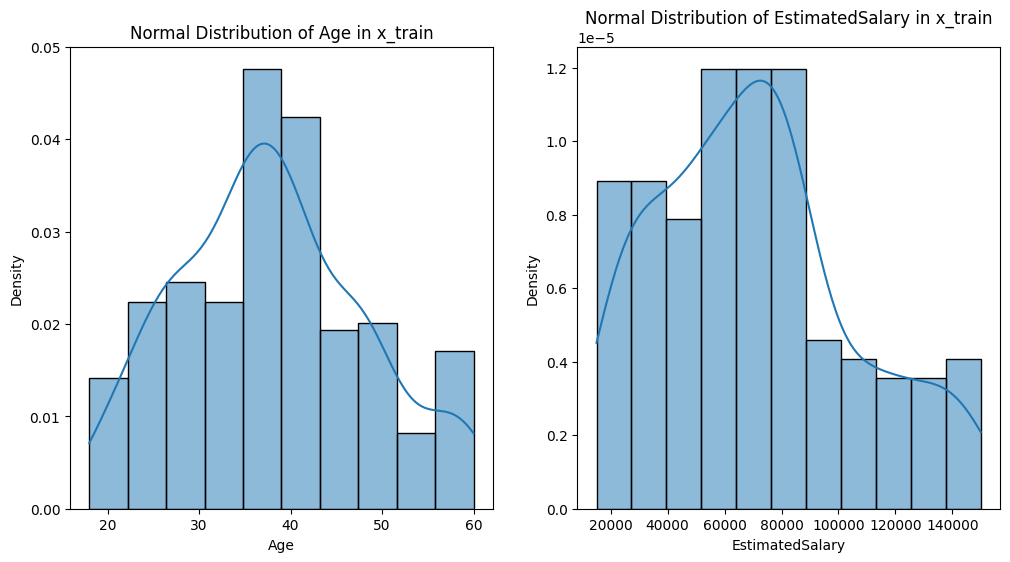

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(x_train["Age"], kde=True, stat="density", ax=ax1)
ax1.set_xlabel("Age")
ax1.set_ylabel("Density")
ax1.set_title("Normal Distribution of Age in x_train")


sns.histplot((x_train["EstimatedSalary"]), kde=True, stat="density", ax=ax2)
ax2.set_xlabel("EstimatedSalary")
ax2.set_ylabel("Density")
ax2.set_title("Normal Distribution of EstimatedSalary in x_train")
plt.show()

In [29]:
data.drop(["Gender", "User ID"], axis=1).corr()

,Age,EstimatedSalary,Purchased
Age,1.000000,0.155238,0.622454
EstimatedSalary,0.155238,1.000000,0.362083
Purchased,0.622454,0.362083,1.000000


Seems like EstimatedSalary is weakly related to the target..at least linearily

Let's explore more!

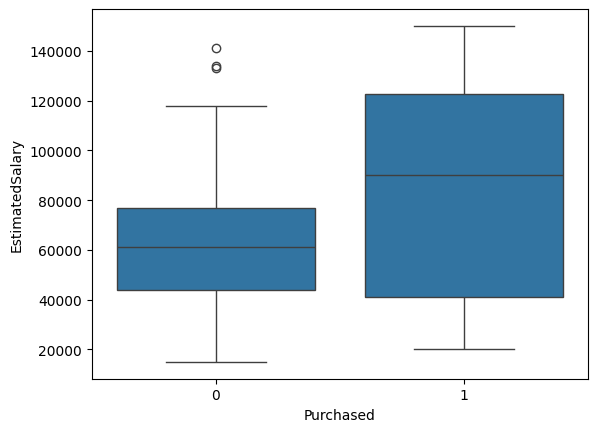

In [30]:
sns.boxplot(x=data["Purchased"], y=data["EstimatedSalary"])
plt.show()

This shows that people with higher salaries tend to buy more, however, since it is still spread out, it doesn't give a particularily sharp decision boundary...let's try to make a log-odds binning graph to see the relation between the target and EstimatedSalary

/tmp/ipykernel_65724/2722648527.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data.groupby('SalaryBin')[['EstimatedSalary']].mean()
/tmp/ipykernel_65724/2722648527.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_purchased = data.groupby('SalaryBin')[['Purchased']].mean()


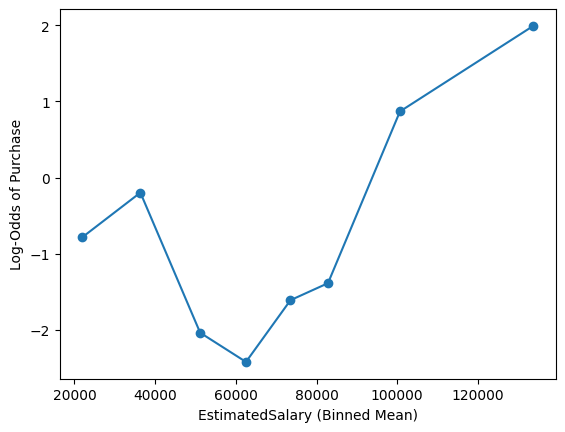

In [31]:
data['SalaryBin'] = pd.qcut(data['EstimatedSalary'], q=8)
bin_means = data.groupby('SalaryBin')[['EstimatedSalary']].mean()
bin_purchased = data.groupby('SalaryBin')[['Purchased']].mean()
log_odds = np.log(bin_purchased / (1 - bin_purchased))

plt.plot(bin_means, log_odds, marker='o')
plt.xlabel("EstimatedSalary (Binned Mean)")
plt.ylabel("Log-Odds of Purchase")
plt.show()

A wildly non-linear relationship, which explains why adding this feature to the training process degrades performance, since it violated the linear assumption of Logistic Regression, however, I think we can do something about that

In [32]:
data["SalaryBin"].unique()

[(14999.999, 28000.0], (28000.0, 43000.0], (43000.0, 57000.0], (70000.0, 78000.0], (57000.0, 70000.0], (78000.0, 88000.0], (115125.0, 150000.0], (88000.0, 115125.0]]
Categories (8, interval[float64, right]): [(14999.999, 28000.0] < (28000.0, 43000.0] < (43000.0, 57000.0] < (57000.0, 70000.0] < (70000.0, 78000.0] < (78000.0, 88000.0] < (88000.0, 115125.0] < (115125.0, 150000.0]]

In [33]:
ord_enc = OrdinalEncoder()
data[["SalaryBin"]] = ord_enc.fit_transform(data[["SalaryBin"]])

In [34]:
data

,User ID,Gender,Age,EstimatedSalary,Purchased,SalaryBin
0,15624510,Male,19,19000,0,0.0
1,15810944,Male,35,20000,0,0.0
2,15668575,Female,26,43000,0,1.0
3,15603246,Female,27,57000,0,2.0
4,15804002,Male,19,76000,0,4.0
...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1.0
396,15706071,Male,51,23000,1,0.0
397,15654296,Female,50,20000,1,0.0
398,15755018,Male,36,33000,0,1.0


In [35]:
one_hot = OneHotEncoder()
enc = one_hot.fit_transform(data[["SalaryBin"]])
data[one_hot.categories_[0]] = enc.toarray()

In [36]:
data

,User ID,Gender,Age,EstimatedSalary,Purchased,SalaryBin,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
0,15624510,Male,19,19000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15810944,Male,35,20000,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15668575,Female,26,43000,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15603246,Female,27,57000,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,15804002,Male,19,76000,0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,15691863,Female,46,41000,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
396,15706071,Male,51,23000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,15654296,Female,50,20000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,15755018,Male,36,33000,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


What we did is basically giving the model a sort of tree-like approach, where it checks what "bin" the EstimatedSalary falls into, and based on that it checks weather this person will buy or not (and the age of coarse)

Also, I chose 8 bins because after testing multiple values, 8 proved to be the best

In [37]:
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:, 2:].drop(["Purchased", "SalaryBin", "EstimatedSalary"], axis=1), data["Purchased"], test_size=0.2, random_state=42)

In [38]:
x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
 [[50  2]
 [ 2 26]]
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.93      0.93      0.93        28

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



This got us the best model yet with an F1-Score of 0.93 and an accuracy of 0.95!

In [ ]:
x_train.head()

,Age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
3,27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
18,46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
250,44,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
274,57,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
71,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
270,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
348,39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
# Save the model
with open("apps/DataInput/Social_Media_Ads_Model.pkl", "wb") as f:
    pkl.dump(log_reg, f)